<a href="https://colab.research.google.com/github/ayushiitbhu2800/Medium-Term-Load-Forecasting/blob/main/Medium_Term_Load_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

Cloning the repository for Data Set

In [40]:
! git clone https://github.com/ayushiitbhu2800/Medium-Term-Load-Forecasting;

fatal: destination path 'Medium-Term-Load-Forecasting' already exists and is not an empty directory.


Reading the Data Set from the repository for further analysis

In [41]:
data_set_unformatted=pd.read_csv("/content/Medium-Term-Load-Forecasting/full_dataset.csv",index_col=None);

In [42]:
data_set_unformatted

,date,year,month,day,weekday,hour,demand,temperature,humd
0,01-01-2004 00:00,2004,1,1,5,0,14703,1.4,59.0
1,01-01-2004 01:00,2004,1,1,5,1,14130,1.4,64.0
2,01-01-2004 02:00,2004,1,1,5,2,13575,1.6,65.0
3,01-01-2004 03:00,2004,1,1,5,3,13280,2.0,64.0
4,01-01-2004 04:00,2004,1,1,5,4,13219,2.0,65.0
...,...,...,...,...,...,...,...,...,...
140251,31-12-2019 19:00,2019,12,31,3,19,15909,0.7,68.0
140252,31-12-2019 20:00,2019,12,31,3,20,15198,0.4,69.0
140253,31-12-2019 21:00,2019,12,31,3,21,14678,0.2,68.0
140254,31-12-2019 22:00,2019,12,31,3,22,14136,-0.1,69.0


In [43]:
data_set_unformatted=data_set_unformatted.rename(columns={"date":"Time"})
data_set_unformatted

,Time,year,month,day,weekday,hour,demand,temperature,humd
0,01-01-2004 00:00,2004,1,1,5,0,14703,1.4,59.0
1,01-01-2004 01:00,2004,1,1,5,1,14130,1.4,64.0
2,01-01-2004 02:00,2004,1,1,5,2,13575,1.6,65.0
3,01-01-2004 03:00,2004,1,1,5,3,13280,2.0,64.0
4,01-01-2004 04:00,2004,1,1,5,4,13219,2.0,65.0
...,...,...,...,...,...,...,...,...,...
140251,31-12-2019 19:00,2019,12,31,3,19,15909,0.7,68.0
140252,31-12-2019 20:00,2019,12,31,3,20,15198,0.4,69.0
140253,31-12-2019 21:00,2019,12,31,3,21,14678,0.2,68.0
140254,31-12-2019 22:00,2019,12,31,3,22,14136,-0.1,69.0


In [44]:
data_set_unformatted

,Time,year,month,day,weekday,hour,demand,temperature,humd
0,01-01-2004 00:00,2004,1,1,5,0,14703,1.4,59.0
1,01-01-2004 01:00,2004,1,1,5,1,14130,1.4,64.0
2,01-01-2004 02:00,2004,1,1,5,2,13575,1.6,65.0
3,01-01-2004 03:00,2004,1,1,5,3,13280,2.0,64.0
4,01-01-2004 04:00,2004,1,1,5,4,13219,2.0,65.0
...,...,...,...,...,...,...,...,...,...
140251,31-12-2019 19:00,2019,12,31,3,19,15909,0.7,68.0
140252,31-12-2019 20:00,2019,12,31,3,20,15198,0.4,69.0
140253,31-12-2019 21:00,2019,12,31,3,21,14678,0.2,68.0
140254,31-12-2019 22:00,2019,12,31,3,22,14136,-0.1,69.0


In [45]:
data_set_unformatted["Time"]=pd.to_datetime(data_set_unformatted[['year','month','day','hour']]);

In [46]:
data_set_unformatted

,Time,year,month,day,weekday,hour,demand,temperature,humd
0,2004-01-01 00:00:00,2004,1,1,5,0,14703,1.4,59.0
1,2004-01-01 01:00:00,2004,1,1,5,1,14130,1.4,64.0
2,2004-01-01 02:00:00,2004,1,1,5,2,13575,1.6,65.0
3,2004-01-01 03:00:00,2004,1,1,5,3,13280,2.0,64.0
4,2004-01-01 04:00:00,2004,1,1,5,4,13219,2.0,65.0
...,...,...,...,...,...,...,...,...,...
140251,2019-12-31 19:00:00,2019,12,31,3,19,15909,0.7,68.0
140252,2019-12-31 20:00:00,2019,12,31,3,20,15198,0.4,69.0
140253,2019-12-31 21:00:00,2019,12,31,3,21,14678,0.2,68.0
140254,2019-12-31 22:00:00,2019,12,31,3,22,14136,-0.1,69.0


In [47]:
data_set_unformatted=data_set_unformatted.set_index("Time");

In [48]:
data_set_unformatted

,year,month,day,weekday,hour,demand,temperature,humd
Time,,,,,,,,
2004-01-01 00:00:00,2004,1,1,5,0,14703,1.4,59.0
2004-01-01 01:00:00,2004,1,1,5,1,14130,1.4,64.0
2004-01-01 02:00:00,2004,1,1,5,2,13575,1.6,65.0
2004-01-01 03:00:00,2004,1,1,5,3,13280,2.0,64.0
2004-01-01 04:00:00,2004,1,1,5,4,13219,2.0,65.0
...,...,...,...,...,...,...,...,...
2019-12-31 19:00:00,2019,12,31,3,19,15909,0.7,68.0
2019-12-31 20:00:00,2019,12,31,3,20,15198,0.4,69.0
2019-12-31 21:00:00,2019,12,31,3,21,14678,0.2,68.0


We can now drop the year, month, day weekday, hour column as they are of no significance to us now. 

In [49]:
drop_cols=["year","month","day","hour"];
df=data_set_unformatted.drop(drop_cols,axis=1);

We have our final dataframe as follows denoted by "df"

In [50]:
df=df.rename(columns={"weekday":"Weekday","time":"Time","demand":"Demand","temperature":"Temperature","humd":"Humidity"});

In [51]:
df

,Weekday,Demand,Temperature,Humidity
Time,,,,
2004-01-01 00:00:00,5,14703,1.4,59.0
2004-01-01 01:00:00,5,14130,1.4,64.0
2004-01-01 02:00:00,5,13575,1.6,65.0
2004-01-01 03:00:00,5,13280,2.0,64.0
2004-01-01 04:00:00,5,13219,2.0,65.0
...,...,...,...,...
2019-12-31 19:00:00,3,15909,0.7,68.0
2019-12-31 20:00:00,3,15198,0.4,69.0
2019-12-31 21:00:00,3,14678,0.2,68.0


In [75]:
df["Weekday"] = df["Weekday"].apply(lambda x : 1 if x < 6 else 0)

Data Set Cleaning

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140256 entries, 2004-01-01 00:00:00 to 2019-12-31 23:00:00
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Weekday      140256 non-null  int64  
 1   Demand       140256 non-null  int64  
 2   Temperature  140256 non-null  float64
 3   Humidity     140256 non-null  float64
 4   sin_hour     140256 non-null  float64
 5   cos_hour     140256 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 11.5 MB


In [77]:
print("There should be total {0} entries in the Temperature and Humidity columns".format(((2019-2004+1)*365+4)*24));

There should be total 140256 entries in the Temperature and Humidity columns


Here we can clearly notice that some of the cells in Temperature and Humidity are missing while all of them are present in Demand column

There are many methods to fill in these null values:

1.   Interpolation
2.   Frequency method
3.   Backfill(row-wise, column-wise)
4.   Frontfill(row-wise, column-wise)



Here we will proceed by using backfill row-wise method which is inbuilt in pandas it replaces the null values by the values in the next row.

In [78]:
df["Temperature"]=df["Temperature"].bfill();
df["Humidity"]=df["Humidity"].bfill();

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140256 entries, 2004-01-01 00:00:00 to 2019-12-31 23:00:00
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Weekday      140256 non-null  int64  
 1   Demand       140256 non-null  int64  
 2   Temperature  140256 non-null  float64
 3   Humidity     140256 non-null  float64
 4   sin_hour     140256 non-null  float64
 5   cos_hour     140256 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 11.5 MB


In [80]:
df["Temperature"]=(df["Temperature"]*9)/5+32;
df["Humidity"]=df["Humidity"]/100;

In [81]:
df['sin_hour'] = np.sin(2*np.pi*df.index.hour.values/24)
df['cos_hour'] = np.cos(2*np.pi*df.index.hour.values/24)
df

,Weekday,Demand,Temperature,Humidity,sin_hour,cos_hour
Time,,,,,,
2004-01-01 00:00:00,1,14703,94.136,0.0059,0.000000,1.000000
2004-01-01 01:00:00,1,14130,94.136,0.0064,0.258819,0.965926
2004-01-01 02:00:00,1,13575,94.784,0.0065,0.500000,0.866025
2004-01-01 03:00:00,1,13280,96.080,0.0064,0.707107,0.707107
2004-01-01 04:00:00,1,13219,96.080,0.0065,0.866025,0.500000
...,...,...,...,...,...,...
2019-12-31 19:00:00,1,15909,91.868,0.0068,-0.965926,0.258819
2019-12-31 20:00:00,1,15198,90.896,0.0069,-0.866025,0.500000
2019-12-31 21:00:00,1,14678,90.248,0.0068,-0.707107,0.707107


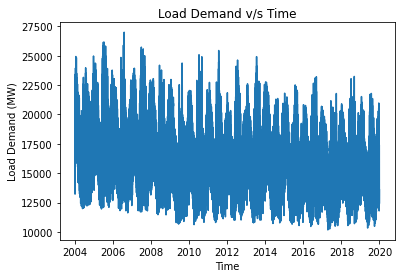

<Figure size 1440x864 with 0 Axes>

In [82]:
plt.plot(df["Demand"])
plt.xlabel("Time");
plt.ylabel("Load Demand (MW)");
plt.title("Load Demand v/s Time");
plt.figure(figsize=(20,12));

Feature scaling is used to bring all values into the range [0,1]. This is also called unity-based normalization. This can be generalized to restrict the range of values in the dataset between any arbitrary points **a** and **b**.
We normalize our data of Load and Temperature using Min-Max Scaler.

In [83]:
scaler=MinMaxScaler()
df_norm=df.copy()
df_norm[["Temperature","Demand"]]=scaler.fit_transform(df_norm[["Temperature","Demand"]])

In [84]:
df_norm.head()

,Weekday,Demand,Temperature,Humidity,sin_hour,cos_hour
Time,,,,,,
2004-01-01 00:00:00,1,0.269391,0.423077,0.0059,0.000000,1.000000
2004-01-01 01:00:00,1,0.235360,0.423077,0.0064,0.258819,0.965926
2004-01-01 02:00:00,1,0.202399,0.426282,0.0065,0.500000,0.866025
2004-01-01 03:00:00,1,0.184879,0.432692,0.0064,0.707107,0.707107
2004-01-01 04:00:00,1,0.181257,0.432692,0.0065,0.866025,0.500000


# **Regression Model                                                                         For hourly Residuals**

Here we convert / transform the load demand using a lambda function in python and setting it to **load_data - mean_of_load_data**

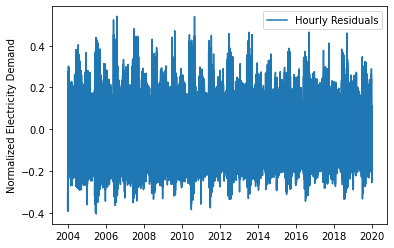

In [85]:
hourly_res_norm = df_norm.copy()
hourly_res_norm['Demand'] = df_norm['Demand'].groupby(pd.Grouper(freq='M')).transform(lambda x: x - x.mean())
plt.plot(hourly_res_norm['Demand'], label='Hourly Residuals');
plt.ylabel('Normalized Electricity Demand')
plt.legend();

We need proper dataset for our model hence we need to divide the dataset into three parts:


1.   Train Data
2.   Test Data
3.   Validation Data



In [86]:
train = hourly_res_norm[:'2016']              # Training data consists of time duration 2004 to 2016
validate = hourly_res_norm['2017':'2018']     # Validation data consists of time duration 2017 to 2018
test = hourly_res_norm['2019':]               # Test data consists of time duration 2019 to 2020

Dividing dataset into **X_tr** (X training) and **y_tr** (y training)

In [87]:
# setup training variables 
exog_tr = train.iloc[:,1:].values
ar_tr = train['Demand'].shift().bfill().values[:,None]
X_tr = np.hstack([ar_tr, exog_tr])
y_tr = train['Demand'].values

In [88]:
# setup validation variables
exog_val = validate.iloc[:,1:].values
y_val = validate['Demand'].values

In [89]:
# setup testing variables
exog_te = test.iloc[:,1:].values

In [90]:
yp_full = hourly_res_norm.loc[:'2018','Demand']
yp_val = hourly_res_norm.loc['2017':'2018','Demand']
yp_te = hourly_res_norm.loc['2019':,'Demand']
y_init_val = np.hstack([y_tr[-1], validate.iloc[167::168,0].values])
y_init_te = np.hstack([y_val[-1], test.iloc[167::168,0].values])

Computation of Mean Absolute Error

In [97]:
def compute_mae(y, yhat):
    """
    Input- Predicted Values, Observed Values respectively
    Output- Mean Absolute Error
    
    """
    return np.mean(np.abs(yhat - y))

Forecasting Function

In [98]:
def forecast(model, exog, y_init):
    """
    Input- Trained model, Exogenous Features, and Initial AR term
    Output- Forecasting Predictions
    
    """
    yhat = []
    Xi_te = np.hstack([y_init, exog[0]])[None,:]
    for i in range(len(exog)-1):
        yhat_i = model.predict(Xi_te)[0]
        yhat.append(yhat_i)
        Xi_te = np.hstack([yhat_i, exog[i+1]])[None,:]
    yhat.append(model.predict(Xi_te)[0])
    return np.array(yhat)

Forecasting based on weekly basis

In [ ]:
def weekly_forecast(model, exog, y_init):
    """
    Input- Trained odel exogenous features, and initial AR term, makes a series of 1-week-out forecasts"""
    yhat = []
    for i, yi in enumerate(y_init):
        exog_i = exog[168*i:168*(i+1),:]
        if exog_i.shape[0] < 1:
            break
        yhat.append(forecast(model, exog_i, yi))
    return np.hstack(yhat)

In [ ]:
def plot_full(y, yhat, yhat_idx):
    """plots observed and forecasted values for the full date range"""
    pred = pd.Series(yhat, index=yhat_idx)
    plt.figure()
    plt.plot(y, label='Observed')
    plt.plot(pred, label='Forecast', ls='--')
    plt.ylabel('Normalized Hourly Residual Electricity Demand')
    plt.legend()

In [ ]:
def plot_week(y, yhat, yhat_idx):
    """plots observed and forecasted values for one week span"""
    pred = pd.Series(yhat, index=yhat_idx)
    fig = plt.figure();
    plt.plot(y['2018-12-01':'2018-12-07'], label='Observed')
    plt.plot(pred['2018-12-01':'2018-12-07'], label='Forecast', ls='--')
    plt.ylabel('Normalized Hourly Residual Electricity Demand')
    plt.legend()
    fig.autofmt_xdate()

## **Baseline Model**

MAE: 0.09911849067765258


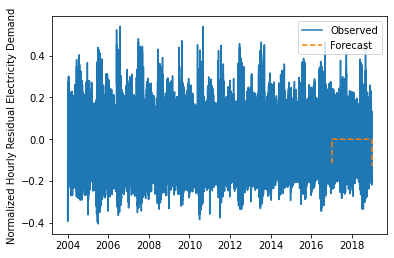

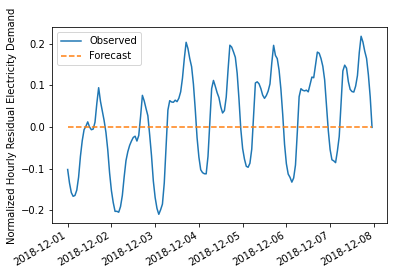

In [92]:
# get forecast "predictions" from the baseline persistance model
idx = validate.index[::168]
idx = idx.append(pd.DatetimeIndex(['2018-12-31 23']))
pred = pd.Series(np.hstack([y_init_val, yp_val.iloc[-1]]), index=idx)
pred = pred.resample('H').ffill().values

# compute error, and plot on both long and short time scales
print('MAE:', compute_mae(y_val, pred))
plot_full(yp_full, pred, yp_val.index)
plot_week(yp_full, pred, yp_val.index)

##**Linear Regression**

In [93]:
from sklearn.linear_model import LinearRegression

# train model and get predictions
mod_lr = LinearRegression()
mod_lr.fit(X_tr, y_tr)
pred = weekly_forecast(mod_lr, exog_val, y_init_val)

MAE: 1.115486768736778e-16


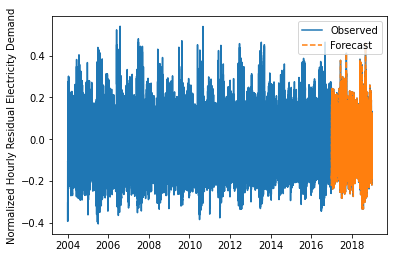

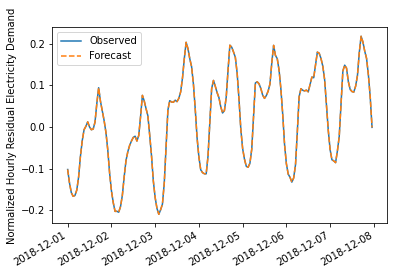

In [94]:
# compute error, and plot on both long and short time scales
print('MAE:', compute_mae(y_val, pred))
plot_full(yp_full, pred, yp_val.index)
plot_week(yp_full, pred, yp_val.index)